In [12]:
from nes_py.wrappers import JoypadSpace
import gym_tetris
from gym_tetris.actions import SIMPLE_MOVEMENT,MOVEMENT
import numpy as np
import random
import numpy as np
from matplotlib import pyplot as plt

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque

device = torch.device("cpu")


In [14]:
def statePreprocess(state):
    #the shape of the play area is from 48 to 208 in the x direction and 96 to 176 in the y direction
    state = state[48:208,96:176]
    grayscale = np.dot(state[...,:3], [0.2989, 0.5870, 0.1140])
    binary_array = grayscale.reshape(20,8,10,8).max(axis=(1,3)) > 0
    return binary_array.astype(int)

In [15]:
def one_hot_piece(piece):
    # Extended mapping to include variations like 'Td', 'Ld', etc.
    mapping = {
    'Tu': 0,
    'Tr': 1,
    'Td': 2,
    'Tl': 3,
    'Jl': 4,
    'Ju': 5,
    'Jr': 6,
    'Jd': 7,
    'Zh': 8,
    'Zv': 9,
    'O': 10,
    'Sh': 11,
    'Sv': 12,
    'Lr': 13,
    'Ld': 14,
    'Ll': 15,
    'Lu': 16,
    'Iv': 17,
    'Ih': 18}
    vector = [0] * len(mapping)
    if piece in mapping:  # Check if the piece is recognized
        vector[mapping[piece]] = 1
    else:
        print('Piece not recognized:', piece)
    return vector

In [16]:
env = gym_tetris.make('TetrisA-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
state = env.reset()
##state =torch.tensor(np.array(state, copy = True), dtype=torch.float32)


Ld
Sh


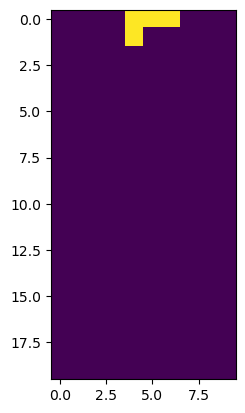

In [17]:
state, reward, done, info = env.step(0)
current_piece = info['current_piece']
next_piece = info['next_piece']

print(current_piece)
print(next_piece)

#drwaing the state
plt.imshow(statePreprocess(state))

In [18]:
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.conv1 = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.conv3 = nn.Sequential(nn.Linear(128, 128), nn.ReLU())
        self.fc = nn.Linear(128, output_dim)
        
        self._create_weights()
        
    def _create_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc(x)
        return x

In [19]:
def process_state(grid, current_piece, next_piece):
    grid = statePreprocess(grid)
    # Flatten the grid
    flat_grid = grid.reshape(-1).astype(float)  # Convert grid to a flat, float array

    # One-hot encode the current and next pieces
    current_piece_vector = one_hot_piece(current_piece)
    next_piece_vector = one_hot_piece(next_piece)

    # Combine the flattened grid and the piece vectors into one state vector
    return torch.tensor(np.concatenate([flat_grid, current_piece_vector, next_piece_vector]), dtype=torch.float32)

In [20]:
def empty_blocks(grid, height_limit=None):
    penalty = 0
    grid_height, grid_width = grid.shape
    if height_limit is not None:
        grid_height = min(grid_height, height_limit)
    
    for col in range(grid_width):
        column = grid[:grid_height, col]
        filled = False
        local_penalty = 0
        for row in reversed(column):  # Start from the bottom of the grid
            if row > 0:
                filled = True
            elif row == 0 and filled:
                local_penalty += 1
        penalty += local_penalty
    
    return penalty


In [21]:
# Initialize the DQN
input_dim = 200 + 19 +19  # 200 for the grid, 14 for the one-hot encoded pieces
output_dim = len(SIMPLE_MOVEMENT)  # Number of possible actions
model = DQN(input_dim, output_dim)
model.to(device)

# Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Initialize the replay memory
replay_memory = deque(maxlen = 10000)
batch_size = 128

epsilon = 1.0  # Starting value of epsilon
epsilon_min = 0.01  # Minimum value of epsilon
epsilon_decay = 0.995  # Decay multiplier for epsilon

Episode 1, total reward: -238.0


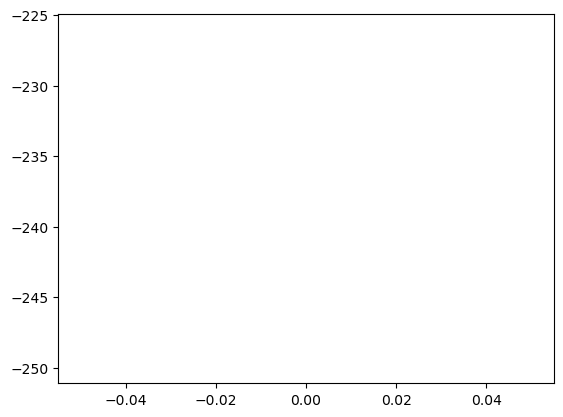

Episode 2, total reward: -241.0
Episode 3, total reward: -242.0
Episode 4, total reward: -242.0
Episode 5, total reward: -237.0
Episode 6, total reward: -313.0
Episode 7, total reward: -307.0
Episode 8, total reward: -307.0
Episode 9, total reward: -234.0
Episode 10, total reward: -257.0
Episode 11, total reward: -301.0
Episode 12, total reward: -240.0
Episode 13, total reward: -240.0
Episode 14, total reward: -230.0
Episode 15, total reward: -275.0
Episode 16, total reward: -237.0
Episode 17, total reward: -244.0
Episode 18, total reward: -256.0
Episode 19, total reward: -254.0
Episode 20, total reward: -246.0
Episode 21, total reward: -246.0


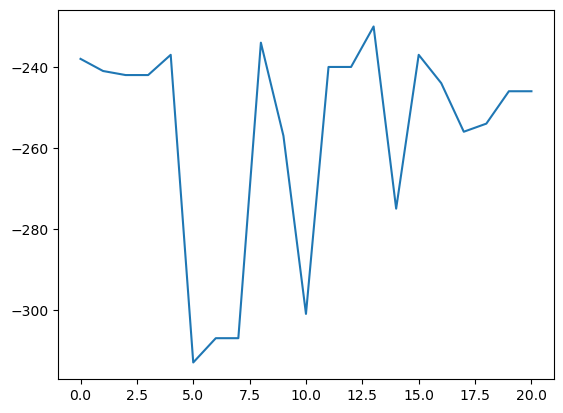

Episode 22, total reward: -254.0
Episode 23, total reward: -253.0
Episode 24, total reward: -257.0
Episode 25, total reward: -239.0
Episode 26, total reward: -247.0
Episode 27, total reward: -255.0
Episode 28, total reward: -319.0
Episode 29, total reward: -252.0
Episode 30, total reward: -301.0
Episode 31, total reward: -318.0
Episode 32, total reward: -299.0
Episode 33, total reward: -286.0


KeyboardInterrupt: 

In [22]:
#number of episodes
episodes = 10000

env = gym_tetris.make('TetrisA-v3')
env = JoypadSpace(env, SIMPLE_MOVEMENT)
model.train()

episode_rewards = []

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

for episode in range(episodes):
    state = env.reset()
    state, reward, done, info = env.step(0)
    current_piece = info['current_piece']
    next_piece = info['next_piece']
    state = process_state(state, current_piece, next_piece)
    total_reward = 0
    oldEmptyPanalty = 0
    oldClear = 0
    oldHeight = 0
    while not done:
        # Exploration vs Exploitation
        if random.random() < epsilon:
            action = random.randint(0, 5)
        else:
            q_values = model(state)
            action = torch.argmax(q_values).item()

        # Step in the environment
        next_state, reward, done, info = env.step(action)
        #env.render()
        next_current_piece = info['current_piece']
        next_next_piece = info['next_piece']
        grid = statePreprocess(next_state)
        next_state = process_state(next_state, next_current_piece, next_next_piece)
        
        # Custom reward function
        newClear = info['number_of_lines']
        clear = newClear - oldClear
        newEmptyPanalty = empty_blocks(grid)
        difference = newEmptyPanalty - oldEmptyPanalty
        
        newHeight = info['board_height']
        hightDifference = newHeight - oldHeight
        
        reward = reward + clear * 1000 - difference * 1 - hightDifference * 10
        
        # Save to replay buffer
        replay_memory.append((state, torch.tensor([action]), torch.tensor([reward], dtype=torch.float32),
                              next_state, torch.tensor([done], dtype=torch.float32)))
        state = next_state
        oldEmptyPanalty = newEmptyPanalty
        oldHeight = newHeight
        oldClear = newClear
        
        
        
        # Training from replay buffer
        if len(replay_memory) >= batch_size:
            batch = random.sample(replay_memory, batch_size)
            state_batch, action_batch, reward_batch, next_state_batch, done_batch = map(torch.stack, zip(*batch))
            
            q_values = model(state_batch)
            with torch.no_grad():
                next_q_values = model(next_state_batch)
            target_q_values = reward_batch + 0.99 * torch.max(next_q_values, dim=1).values * (1 - done_batch)
            loss = loss_fn(q_values[range(batch_size), action_batch], target_q_values)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        
        epsilon = max(epsilon_min, epsilon_decay * epsilon)
        total_reward += reward
    episode_rewards.append(total_reward)
    print(f'Episode {episode + 1}, total reward: {total_reward}')
        
    if episode % 20 == 0:
        torch.save(model.state_dict(), 'model.pth')
        plt.plot(episode_rewards)
        plt.show()
    
